In [1]:
import time
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.layers import Conv2D, Dense, Dropout, GlobalMaxPooling2D, Input, Flatten, MaxPooling2D, Lambda, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# paths to data directory
data_dir = 'C:/Users/miche/NN/ML_hw2/Data'

datagen = ImageDataGenerator(rescale=1 / 255.0)
datagen_aug = ImageDataGenerator(rescale = 1. / 255,
                             zoom_range=0.1,
                             rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             vertical_flip=False)

batch_size = 9236
generator = datagen.flow_from_directory(
    directory=data_dir,
    target_size=(32, 32),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42)

generator_aug = datagen_aug.flow_from_directory(
    directory=data_dir,
    target_size=(32, 32),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42)

Found 9236 images belonging to 8 classes.
Found 9236 images belonging to 8 classes.


In [3]:
data, y = next(generator)
data_aug, y_aug = next(generator_aug)

print(data.shape)
print(y.shape)

(9236, 32, 32, 3)
(9236, 8)


In [4]:
x_train, x_test, y_train, y_test = train_test_split(data,y,test_size=0.15)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.20)

x_train = np.append(x_train, data_aug, axis=0)
y_train = np.append(y_train, y_aug, axis=0)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(15516, 32, 32, 3)
(1570, 32, 32, 3)
(1386, 32, 32, 3)


In [5]:
train_labels = np.empty(len(y_train), dtype=int)
test_labels = np.empty(len(y_test), dtype=int)
val_labels = np.empty(len(y_val), dtype=int)

for i in range(len(y_train)):
    train_labels[i] = (np.where(y_train[i]==1)[0][0])
    
for i in range(len(y_val)):
    val_labels[i] = (np.where(y_val[i]==1)[0][0])
    
for j in range(len(y_test)):
    test_labels[j] = (np.where(y_test[j]==1)[0][0])

In [6]:
print('Training set shape: ', x_train.shape)
print(y_train.shape)
print('Validation set shape: ', x_val.shape)
print(y_val.shape)
print('Test set shape: ', x_test.shape)
print(y_test.shape)

Training set shape:  (15516, 32, 32, 3)
(15516, 8)
Validation set shape:  (1570, 32, 32, 3)
(1570, 8)
Test set shape:  (1386, 32, 32, 3)
(1386, 8)


In [7]:
class_names = ['Cranberries', 'Furniture_&_Wood_Polishes', 'Lollipops', 'Mineral_Water', 'decorative_tray', 
               'pickled_vegetables', 'salad_bowl', 'steak_knives']

train_counts = np.unique(train_labels, return_counts=True)[1]
val_counts = np.unique(val_labels, return_counts=True)[1]
test_counts = np.unique(test_labels, return_counts=True)[1]

for i in range(8):
    print('Number of samples in the training set belonging to class ', class_names[i], ' = ', train_counts[i])
    print('Number of samples in the validation set belonging to class ', class_names[i], ' = ', val_counts[i])
    print('Number of samples in the test set belonging to class ', class_names[i], ' = ', test_counts[i])
    print()

Number of samples in the training set belonging to class  Cranberries  =  1936
Number of samples in the validation set belonging to class  Cranberries  =  201
Number of samples in the test set belonging to class  Cranberries  =  155

Number of samples in the training set belonging to class  Furniture_&_Wood_Polishes  =  2238
Number of samples in the validation set belonging to class  Furniture_&_Wood_Polishes  =  217
Number of samples in the test set belonging to class  Furniture_&_Wood_Polishes  =  187

Number of samples in the training set belonging to class  Lollipops  =  1932
Number of samples in the validation set belonging to class  Lollipops  =  186
Number of samples in the test set belonging to class  Lollipops  =  168

Number of samples in the training set belonging to class  Mineral_Water  =  1808
Number of samples in the validation set belonging to class  Mineral_Water  =  181
Number of samples in the test set belonging to class  Mineral_Water  =  163

Number of samples in t

In [8]:
print(generator.class_indices.keys())

dict_keys(['Cranberries', 'Furniture___Wood_Polishes', 'Lollipops', 'Mineral_Water', 'decorative_tray', 'pickled_vegetables', 'salad_bowl', 'steak_knives'])


In [9]:
def stampa(ds, ds_labels, class_names):
  fig = plt.figure(figsize=(10,7))
  for i in range(9):
      plt.subplot(3,3,i+1)
      plt.tight_layout()
      plt.imshow(ds[i])
      plt.title("Oggetto: {}".format(class_names[(np.where(ds_labels[i]==1)[0][0])]))
      plt.xticks([])
      plt.yticks([])

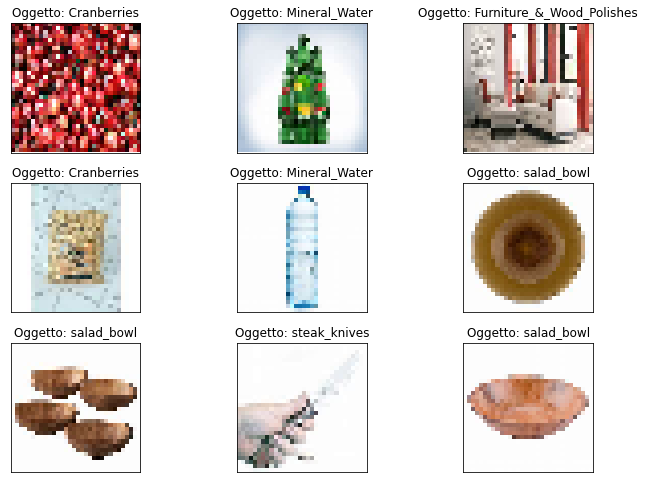

In [10]:
# plotting some samples
stampa(data, y, class_names)

In [11]:
model = Sequential(
    [
        Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu", input_shape=(32,32,3)),
        MaxPooling2D(pool_size=2),
        Dropout(0.3),
        Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"),
        MaxPooling2D(pool_size=2),
        Dropout(0.3),
        Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu"),
        MaxPooling2D(pool_size=2),
        Dropout(0.3),
        Conv2D(256, kernel_size=(3, 3), padding="same", activation="relu"),
        MaxPooling2D(pool_size=2),
        Dropout(0.3),
        GlobalMaxPooling2D(),

        Dense(64, activation='relu'),
        Dense(8, activation='softmax')
    ]
)

In [12]:
# compiling the sequential model
model.compile(loss='mean_squared_error', metrics=['accuracy'], optimizer='adam')

In [13]:
callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
logdir = 'C:/Users/miche/NN/ML_hw2'

In [14]:
history = model.fit(x_train, y_train,
                    batch_size=64, epochs=150,
                    validation_data=(x_val, y_val))

Epoch 1/150
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
243/243 [==============================] - ETA: 0s - loss: 0.0959 - accuracy: 0.3470WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000242992F95E8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and att

243/243 [==============================] - 4s 15ms/step - loss: 0.0249 - accuracy: 0.8660 - val_loss: 0.0307 - val_accuracy: 0.8344
Epoch 101/150
243/243 [==============================] - 4s 14ms/step - loss: 0.0248 - accuracy: 0.8683 - val_loss: 0.0319 - val_accuracy: 0.8325
Epoch 102/150
243/243 [==============================] - 4s 14ms/step - loss: 0.0249 - accuracy: 0.8647 - val_loss: 0.0312 - val_accuracy: 0.8299
Epoch 103/150
243/243 [==============================] - 3s 14ms/step - loss: 0.0254 - accuracy: 0.8630 - val_loss: 0.0310 - val_accuracy: 0.8318
Epoch 104/150
243/243 [==============================] - 4s 14ms/step - loss: 0.0244 - accuracy: 0.8668 - val_loss: 0.0292 - val_accuracy: 0.8465
Epoch 105/150
243/243 [==============================] - 4s 15ms/step - loss: 0.0243 - accuracy: 0.8703 - val_loss: 0.0347 - val_accuracy: 0.8172
Epoch 106/150
243/243 [==============================] - 4s 14ms/step - loss: 0.0251 - accuracy: 0.8652 - val_loss: 0.0318 - val_accuracy:

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         7

In [16]:
def plot_metrics(history):
  # plotting the metrics
  fig = plt.figure()
  plt.subplot(2,1,1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='lower right')

  plt.subplot(2,1,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.tight_layout()

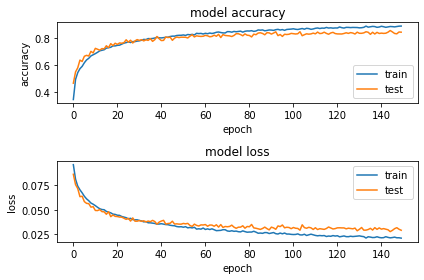

In [17]:
plot_metrics(history)

In [18]:
loss_and_metrics = model.evaluate(x_test, y_test, verbose=2)

print("Test Loss", loss_and_metrics[0])
print("Test Accuracy", loss_and_metrics[1])

44/44 - 0s - loss: 0.0297 - accuracy: 0.8369
Test Loss 0.029704660177230835
Test Accuracy 0.8369408249855042


In [19]:
predicted_classes_crossentropy = np.argmax(model.predict(x_test), axis=-1)

# see which we predicted correctly and which not
correct_indices_crossentropy = np.nonzero(predicted_classes_crossentropy == test_labels)[0]
incorrect_indices_crossentropy = np.nonzero(predicted_classes_crossentropy != test_labels)[0]
print()
print(len(correct_indices_crossentropy)," classified correctly")
print(len(incorrect_indices_crossentropy)," classified incorrectly")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

1160  classified correctly
226  classified incorrectly


In [20]:
t0= time.process_time()
y_pred_sm = model.predict(x_test)
t1 = time.process_time() - t0
print("Time elapsed: ", t1, " seconds")

y_pred = np.argmax(y_pred_sm, axis=1)

Time elapsed:  0.140625  seconds


In [21]:
def stampa_eval(correct_indices, incorrect_indices, predicted_classes):
  # adapt figure size to accomodate 18 subplots
  plt.rcParams['figure.figsize'] = (20,20)

  figure_evaluation = plt.figure()

  # plot 9 correct predictions
  for i, correct in enumerate(correct_indices[:9]):
      plt.subplot(6,3,i+1)
      plt.imshow(x_test[correct], interpolation='none')
      plt.title(
        "Predicted: {}, Truth: {}".format(class_names[predicted_classes[correct]],
                                          class_names[test_labels[correct]]))
      plt.xticks([])
      plt.yticks([])

  # plot 9 incorrect predictions
  for i, incorrect in enumerate(incorrect_indices[:9]):
      plt.subplot(6,3,i+10)
      plt.imshow(x_test[incorrect], interpolation='none')
      plt.title(
        "Predicted {}, Truth: {}".format(class_names[predicted_classes[incorrect]], 
                                        class_names[test_labels[incorrect]]))
      plt.xticks([])
      plt.yticks([])

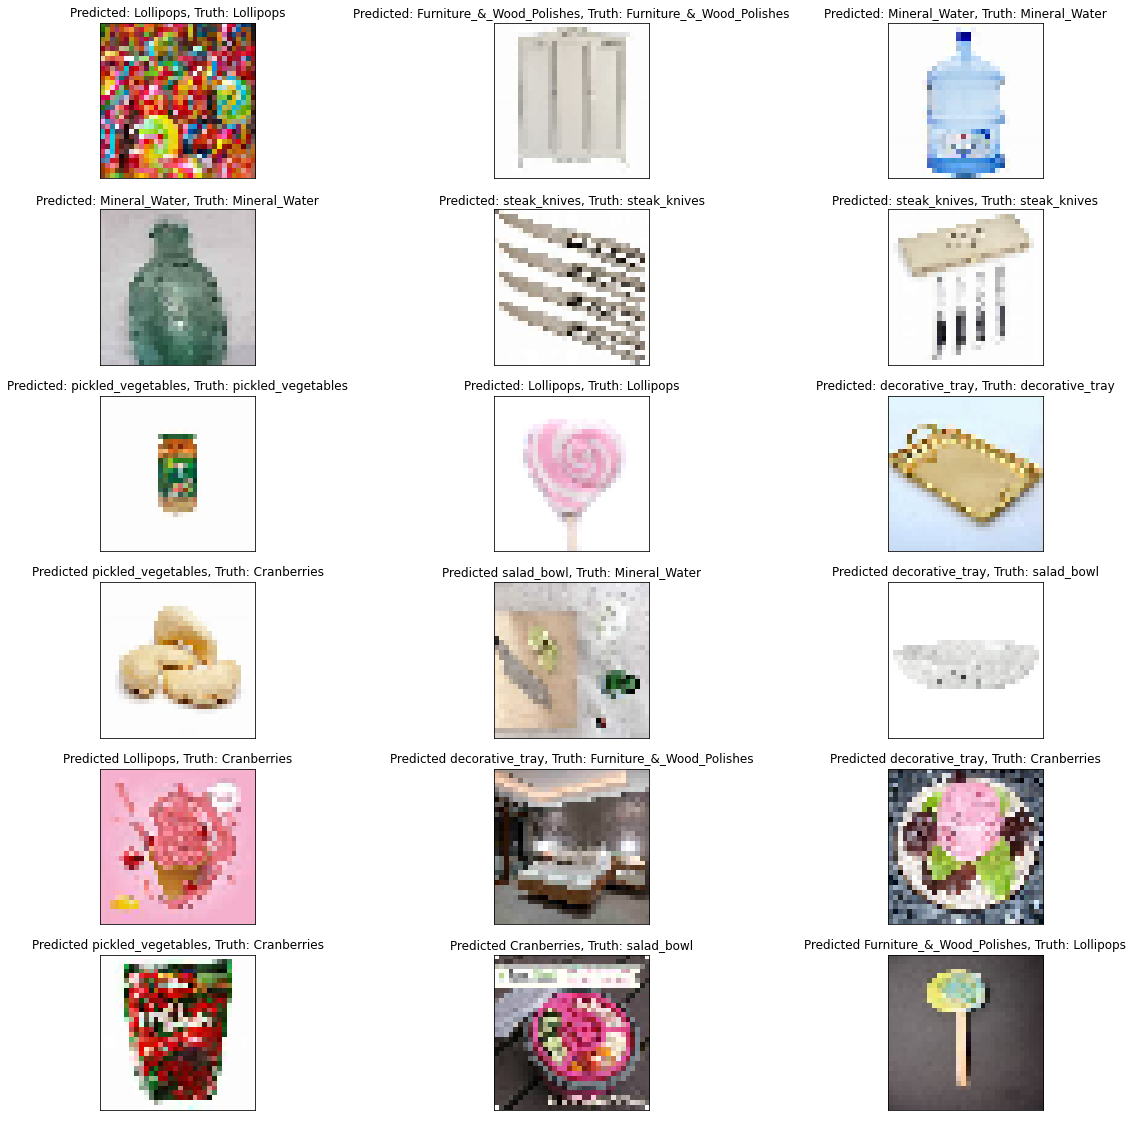

In [22]:
stampa_eval(correct_indices_crossentropy, incorrect_indices_crossentropy, predicted_classes_crossentropy)

In [23]:
acc = model.evaluate(x_test, y_test)
print("Accuracy %.3f" %acc[-1])

44/44 [==============================] - 0s 4ms/step - loss: 0.0297 - accuracy: 0.8369
Accuracy 0.837


In [24]:
print(classification_report(test_labels, y_pred, labels=None))

              precision    recall  f1-score   support

           0       0.69      0.84      0.76       155
           1       0.82      0.89      0.86       187
           2       0.87      0.79      0.83       168
           3       0.97      0.91      0.94       163
           4       0.74      0.81      0.77       180
           5       0.87      0.84      0.86       180
           6       0.87      0.72      0.78       183
           7       0.92      0.90      0.91       170

    accuracy                           0.84      1386
   macro avg       0.84      0.84      0.84      1386
weighted avg       0.84      0.84      0.84      1386



In [25]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

[[130   3   5   0   7   7   2   1]
 [  2 167   1   2   9   1   1   4]
 [ 19   5 133   0   4   3   2   2]
 [  2   0   3 149   3   4   2   0]
 [  6  15   2   1 145   3   6   2]
 [ 13   1   4   0   4 152   5   1]
 [ 10   6   5   2  21   5 131   3]
 [  6   6   0   0   3   0   2 153]]


<AxesSubplot:title={'center':'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

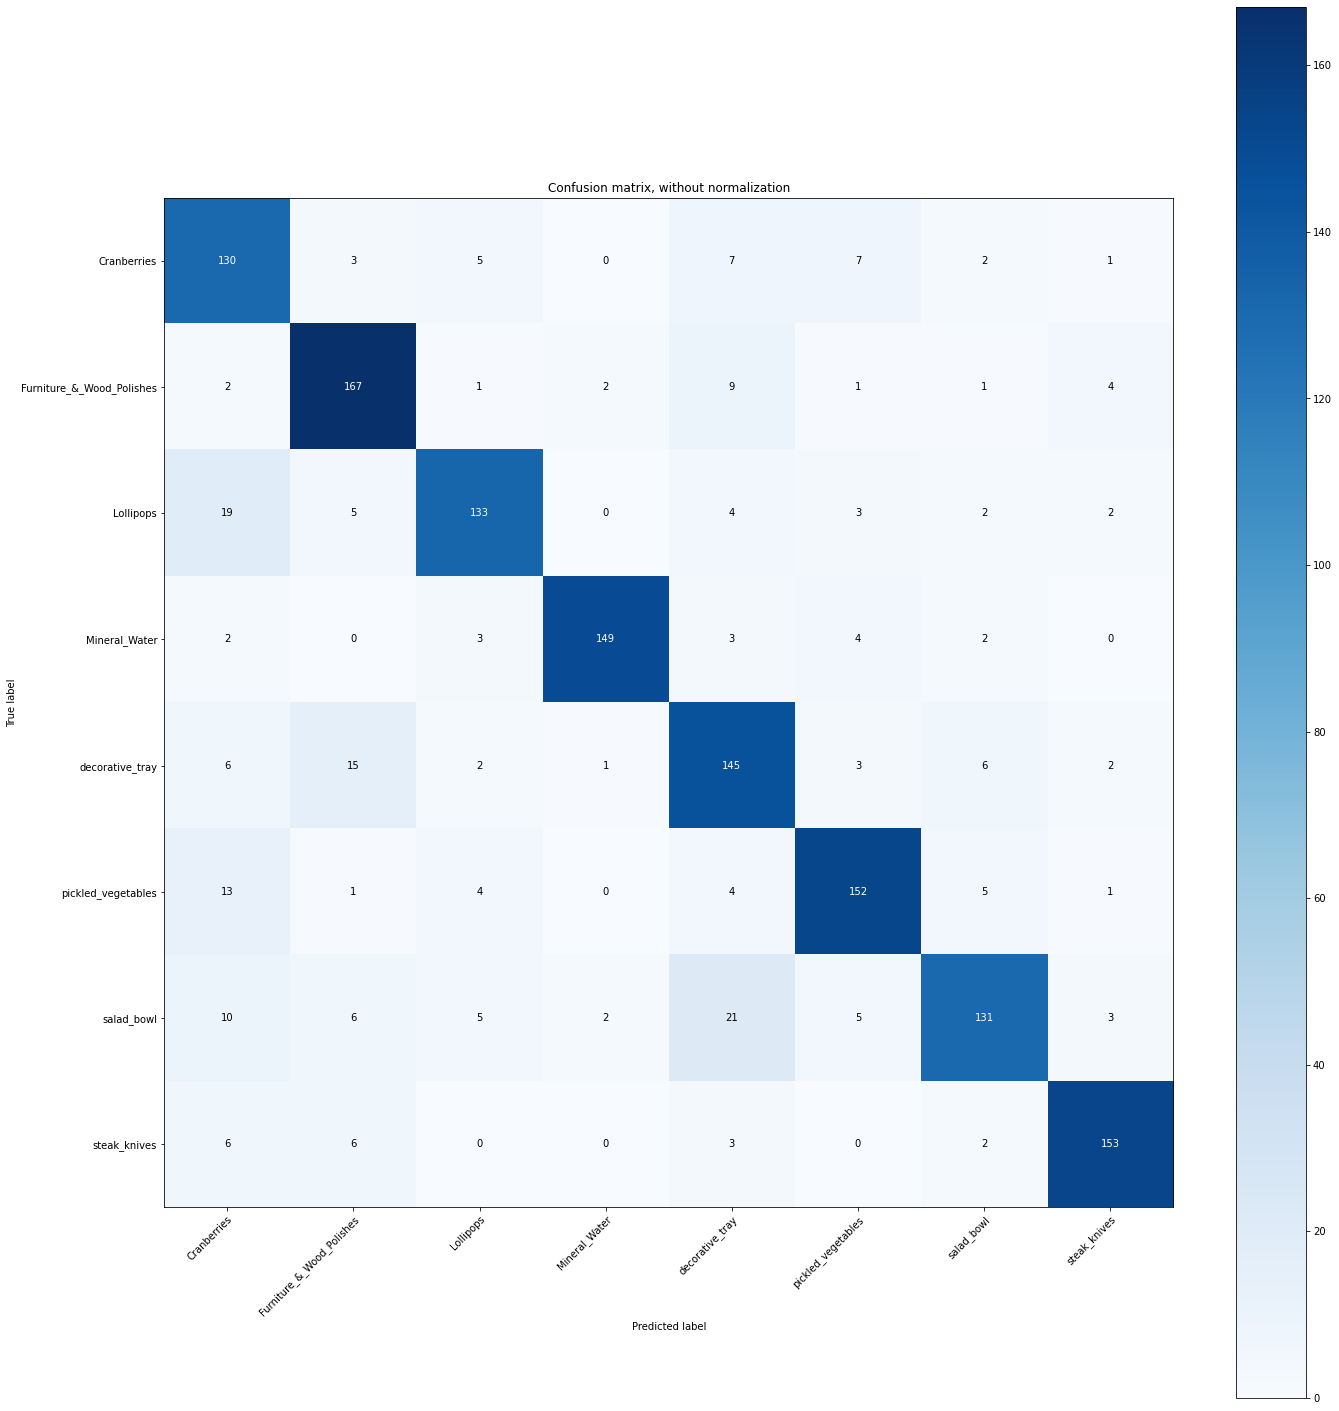

In [26]:
cm = confusion_matrix(test_labels, y_pred, labels=None, sample_weight=None)
print(cm)
plot_confusion_matrix(test_labels, y_pred, classes=class_names, normalize=False)